# 📘 Advanced 2D Surface Fitting with fit() API

> Rotated elliptical Gaussians and multi-peak 2D fitting with global optimization

⏱️ **25-40 minutes** | 📊 **Level: ●●● Advanced** | 🏷️ **Physics** | 🔬 **Optics/Imaging**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/notebooks/09_gallery_advanced/physics/surface_fitting_2d.ipynb)

In [1]:
# @title Install NLSQ (run once in Colab)
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing NLSQ...")
    !pip install -q nlsq
    print("✅ NLSQ installed successfully!")
else:
    print("Not running in Colab - assuming NLSQ is already installed")

Not running in Colab - assuming NLSQ is already installed


## 🔬 Domain Background

**Physical System:** Complex 2D intensity distributions with rotation and multiple peaks

**Model Equations:**

**Rotated Elliptical Gaussian:**
$$z(x,y) = A \exp\left(-\frac{x_r^2}{2\sigma_x^2} - \frac{y_r^2}{2\sigma_y^2}\right) + z_0$$

where the rotated coordinates are:
$$x_r = (x-x_0)\cos\theta + (y-y_0)\sin\theta$$
$$y_r = -(x-x_0)\sin\theta + (y-y_0)\cos\theta$$

**Double Peak Model:**
$$z(x,y) = A_1 e^{-r_1^2/2\sigma_1^2} + A_2 e^{-r_2^2/2\sigma_2^2} + z_0$$

**Common applications:**
- **Astigmatic laser beams** - Beams passing through tilted optical elements
- **Binary star photometry** - Measuring separation and flux ratio of close doubles
- **Multi-source deconvolution** - Separating overlapping sources in images
- **Complex PSF modeling** - Aberrated point spread functions

**Why advanced fitting matters:**
Real-world 2D data often exhibits rotation (tilted optical components) or multiple sources. Standard axis-aligned Gaussians fail in these cases. Global optimization becomes essential when the parameter space has multiple local minima.

---

## 🎯 What You'll Learn

After this tutorial, you will be able to:

- ✓ **Fit rotated 2D Gaussians** with arbitrary orientation angle
- ✓ **Use the fit() API** with presets for different difficulty levels
- ✓ **Apply global optimization** for multi-modal parameter spaces
- ✓ **Fit multiple overlapping peaks** in 2D data
- ✓ **Choose appropriate presets** (fast, robust, global) for 2D problems
- ✓ **Interpret rotation parameters** and handle angle degeneracy

---

## 📊 Parameter Interpretation Guide

### Rotated Gaussian Parameters

| Parameter | Physical Meaning | Typical Range | Challenges |
|-----------|-----------------|---------------|------------|
| $\theta$ | Rotation angle | -π/2 to π/2 | π-periodicity degeneracy |
| $\sigma_x$ | Major axis width | 0.1-10 units | Correlated with θ |
| $\sigma_y$ | Minor axis width | 0.1-10 units | Correlated with θ |

### Multi-Peak Parameters

| Parameter | Physical Meaning | Challenges |
|-----------|-----------------|------------|
| Peak positions | Source locations | Multiple local minima |
| Amplitudes | Source brightness | Can swap between peaks |
| Peak widths | Source sizes | May be poorly constrained if overlapping |

**Key insight:** Rotation angle θ has a fundamental degeneracy:
- θ and θ + π give identical profiles (just swap σ_x and σ_y)
- Restrict bounds to [-π/2, π/2] to break degeneracy
- Global optimization helps find the correct basin

---

## ⚡ Quick Example

```python
import numpy as np
import jax.numpy as jnp
from nlsq import fit

# Define rotated 2D Gaussian
def gaussian_2d_rotated(xy, amp, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = xy[0], xy[1]
    # Rotate coordinates
    xr = (x - x0) * jnp.cos(theta) + (y - y0) * jnp.sin(theta)
    yr = -(x - x0) * jnp.sin(theta) + (y - y0) * jnp.cos(theta)
    return amp * jnp.exp(-(xr**2/(2*sigma_x**2) + yr**2/(2*sigma_y**2))) + offset

# Fit with global optimization (recommended for rotated fits)
popt, pcov = fit(
    gaussian_2d_rotated,
    xdata,  # Shape: (2, n_points)
    z_measured,
    p0=[800, 0, 0, 1.5, 1.5, 0.0, 40],
    bounds=([0, -4, -4, 0.1, 0.1, -np.pi/2, 0],
            [2000, 4, 4, 5, 5, np.pi/2, 200]),
    preset='global',  # Multi-start optimization
    n_starts=15,
)

# Extract rotation angle
theta_deg = np.degrees(popt[5])
print(f"Rotation angle: {theta_deg:.1f} degrees")
```

**Why use `fit()` with `preset='global'`?**
- Rotation angle creates multiple local minima
- Multi-start optimization explores parameter space
- Much more reliable than single-start for rotated fits

---

## 📖 Setup and Model Definition

We'll define three models for this tutorial:
1. **Rotated 2D Gaussian** - For tilted elliptical profiles
2. **Double 2D Gaussian** - For two overlapping sources

In [2]:
# Configure matplotlib for inline plotting
%matplotlib inline

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

from nlsq import fit

# Set random seed for reproducibility
np.random.seed(42)


def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """
    2D Gaussian surface model (axis-aligned ellipse).
    """
    x = xy[0]
    y = xy[1]
    return (
        amplitude
        * jnp.exp(-((x - x0) ** 2 / (2 * sigma_x**2) + (y - y0) ** 2 / (2 * sigma_y**2)))
        + offset
    )


def gaussian_2d_rotated(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    """
    2D Gaussian surface with rotation (tilted ellipse).

    Parameters
    ----------
    xy : ndarray
        Shape (2, n_points) with x, y coordinates.
    amplitude : float
        Peak amplitude.
    x0, y0 : float
        Center coordinates.
    sigma_x, sigma_y : float
        Standard deviations along principal axes.
    theta : float
        Rotation angle in radians.
    offset : float
        Background offset.

    Returns
    -------
    z : ndarray
        Surface values.
    """
    x = xy[0]
    y = xy[1]

    # Rotate coordinates to principal axis frame
    cos_t = jnp.cos(theta)
    sin_t = jnp.sin(theta)
    xr = (x - x0) * cos_t + (y - y0) * sin_t
    yr = -(x - x0) * sin_t + (y - y0) * cos_t

    return amplitude * jnp.exp(-(xr**2 / (2 * sigma_x**2) + yr**2 / (2 * sigma_y**2))) + offset


def double_gaussian_2d(xy, amp1, x01, y01, sigma1, amp2, x02, y02, sigma2, offset):
    """
    Two overlapping 2D Gaussian peaks (circular).

    Parameters
    ----------
    xy : ndarray
        Shape (2, n_points) with x, y coordinates.
    amp1, x01, y01, sigma1 : float
        First peak parameters.
    amp2, x02, y02, sigma2 : float
        Second peak parameters.
    offset : float
        Common background offset.

    Returns
    -------
    z : ndarray
        Combined surface values.
    """
    x = xy[0]
    y = xy[1]

    peak1 = amp1 * jnp.exp(-((x - x01) ** 2 + (y - y01) ** 2) / (2 * sigma1**2))
    peak2 = amp2 * jnp.exp(-((x - x02) ** 2 + (y - y02) ** 2) / (2 * sigma2**2))

    return peak1 + peak2 + offset


print("✅ Model functions defined")

✅ Model functions defined


## 1. Generate 2D Grid Data

First, let's create our 2D grid that will be used for all examples.

In [4]:
print("=" * 70)
print("ADVANCED 2D SURFACE FITTING WITH fit() API")
print("=" * 70)

# Create 2D grid
nx, ny = 60, 60
x_1d = np.linspace(-5, 5, nx)
y_1d = np.linspace(-5, 5, ny)
X, Y = np.meshgrid(x_1d, y_1d)

# Flatten for NLSQ
x_flat = X.flatten()
y_flat = Y.flatten()
n_points = len(x_flat)
xdata = np.vstack([x_flat, y_flat])

print(f"\nGrid: {nx} x {ny} = {n_points} points")
print(f"xdata shape: {xdata.shape}")

ADVANCED 2D SURFACE FITTING WITH fit() API

Grid: 60 x 60 = 3600 points
xdata shape: (2, 3600)


## 2. Example 1: Rotated Elliptical Gaussian

This is a common case in laser optics when beams pass through tilted optical elements or have astigmatism. The rotation angle adds complexity to the fit.

**Why this is challenging:**
- Rotation angle θ has π-periodicity degeneracy
- σ_x, σ_y, and θ are correlated
- Initial guess sensitivity is high

**Solution:** Use `preset='global'` for multi-start optimization

In [5]:
print("\n" + "-" * 70)
print("EXAMPLE 1: ROTATED ELLIPTICAL GAUSSIAN")
print("-" * 70)
print("(Common for tilted optical elements or astigmatic beams)")

# True parameters for rotated Gaussian
amp_true = 1000.0
x0_true = 0.3
y0_true = -0.2
sigma_x_true = 1.8  # Major axis
sigma_y_true = 0.9  # Minor axis (2:1 ellipse)
theta_true = np.pi / 6  # 30 degree rotation
offset_true = 50.0

print("\nTrue Parameters:")
print(f"  Amplitude: {amp_true:.1f}")
print(f"  Center:    ({x0_true:.2f}, {y0_true:.2f})")
print(f"  Sigmas:    {sigma_x_true:.2f} x {sigma_y_true:.2f}")
print(f"  Rotation:  {np.degrees(theta_true):.1f} degrees")
print(f"  Offset:    {offset_true:.1f}")

# Generate data
z_true = gaussian_2d_rotated(
    xdata, amp_true, x0_true, y0_true, sigma_x_true, sigma_y_true, theta_true, offset_true
)
noise = np.random.normal(0, np.sqrt(z_true + 10))
z_measured = z_true + noise
sigma = np.sqrt(z_measured + 10)


----------------------------------------------------------------------
EXAMPLE 1: ROTATED ELLIPTICAL GAUSSIAN
----------------------------------------------------------------------
(Common for tilted optical elements or astigmatic beams)

True Parameters:
  Amplitude: 1000.0
  Center:    (0.30, -0.20)
  Sigmas:    1.80 x 0.90
  Rotation:  30.0 degrees
  Offset:    50.0


In [6]:
# Initial guess (note: theta is difficult to estimate)
p0_rotated = [800, 0.0, 0.0, 1.5, 1.5, 0.0, 40]

# Bounds (theta in [-pi/2, pi/2] to break degeneracy)
bounds_rotated = (
    [0, -4, -4, 0.1, 0.1, -np.pi / 2, 0],
    [2000, 4, 4, 5, 5, np.pi / 2, 200],
)

### Method 1: fit() with preset='fast'

Single-start local optimization. Fast but may miss the global minimum for rotated fits.

In [7]:
print("\nMethod 1: fit() with preset='fast'")
popt_fast, pcov_fast = fit(
    gaussian_2d_rotated,
    xdata,
    z_measured,
    p0=p0_rotated,
    sigma=sigma,
    bounds=bounds_rotated,
    absolute_sigma=True,
    preset="fast",
)

amp_f, x0_f, y0_f, sx_f, sy_f, theta_f, off_f = popt_fast
print(f"  Center: ({x0_f:.3f}, {y0_f:.3f})")
print(f"  Rotation: {np.degrees(theta_f):.1f} deg (true: {np.degrees(theta_true):.1f})")

INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08



Method 1: fit() with preset='fast'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=5.018153s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1823.9941 | elapsed=5.018s | final_gradient_norm=0.0025


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=6.398887s


INFO:nlsq.curve_fit:Curve fit completed total_time=6.3989 | final_cost=3647.9882 | covariance_warning=False


  Center: (0.295, -0.202)
  Rotation: 30.0 deg (true: 30.0)


### Method 2: fit() with preset='robust'

5-start optimization. Better for moderate difficulty, but may still struggle with rotation.

In [8]:
print("\nMethod 2: fit() with preset='robust' (recommended for rotated fits)")
popt_robust, pcov_robust = fit(
    gaussian_2d_rotated,
    xdata,
    z_measured,
    p0=p0_rotated,
    sigma=sigma,
    bounds=bounds_rotated,
    absolute_sigma=True,
    preset="robust",
)

amp_r, x0_r, y0_r, sx_r, sy_r, theta_r, off_r = popt_robust
print(f"  Center: ({x0_r:.3f}, {y0_r:.3f})")
print(f"  Rotation: {np.degrees(theta_r):.1f} deg")

INFO:nlsq.multi_start:Generating 5 starting points using lhs n_starts=5 | sampler=lhs | center_on_p0=True



Method 2: fit() with preset='robust' (recommended for rotated fits)


INFO:nlsq.multi_start:Evaluating 5 starting points


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.675150s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1823.9941 | elapsed=0.675s | final_gradient_norm=2.3858e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=1.207205s


INFO:nlsq.curve_fit:Curve fit completed total_time=1.2072 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.303938s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=2.8831e+04 | elapsed=0.304s | final_gradient_norm=11.9444


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.450451s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4505 | final_cost=5.7662e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.084761s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1823.9941 | elapsed=0.085s | final_gradient_norm=4.8042e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.225910s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2259 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.199138s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1823.9941 | elapsed=0.199s | final_gradient_norm=0.0048


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.323916s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3239 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.084889s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=1823.9941 | elapsed=0.085s | final_gradient_norm=2.9035e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.223213s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2232 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.multi_start:Best starting point: loss=3647.988185 best_loss=3647.9882 | best_params=[7 items]


  Center: (0.295, -0.202)
  Rotation: 30.0 deg


### Method 3: fit() with preset='global'

15-start global optimization. Recommended for rotated fits due to angle degeneracy.

In [9]:
print("\nMethod 3: fit() with preset='global' (15 starts)")
print("  (Global optimization helps with rotation angle degeneracy)")
popt_global, pcov_global = fit(
    gaussian_2d_rotated,
    xdata,
    z_measured,
    p0=p0_rotated,
    sigma=sigma,
    bounds=bounds_rotated,
    absolute_sigma=True,
    preset="global",
    n_starts=15,
)

amp_g, x0_g, y0_g, sx_g, sy_g, theta_g, off_g = popt_global
perr_g = np.sqrt(np.diag(pcov_global))

print("\n  ✅ Global optimization results:")
print(f"  Amplitude: {amp_g:.1f} +/- {perr_g[0]:.1f} (true: {amp_true:.1f})")
print(f"  Center:    ({x0_g:.3f}, {y0_g:.3f})")
print(f"  Sigma_x:   {sx_g:.3f} +/- {perr_g[3]:.3f} (true: {sigma_x_true:.2f})")
print(f"  Sigma_y:   {sy_g:.3f} +/- {perr_g[4]:.3f} (true: {sigma_y_true:.2f})")
print(f"  Rotation:  {np.degrees(theta_g):.1f} +/- {np.degrees(perr_g[5]):.1f} deg (true: {np.degrees(theta_true):.1f})")

# Use global result for visualization
popt = popt_global

INFO:nlsq.multi_start:Generating 15 starting points using lhs n_starts=15 | sampler=lhs | center_on_p0=True



Method 3: fit() with preset='global' (15 starts)
  (Global optimization helps with rotation angle degeneracy)


INFO:nlsq.multi_start:Evaluating 15 starting points


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.683913s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=1823.9941 | elapsed=0.684s | final_gradient_norm=0.0019


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=1.211962s


INFO:nlsq.curve_fit:Curve fit completed total_time=1.2120 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.114687s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1823.9941 | elapsed=0.115s | final_gradient_norm=0.0123


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.247656s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2477 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.090317s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1823.9941 | elapsed=0.090s | final_gradient_norm=1.1771e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.220260s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2203 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.096416s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1823.9941 | elapsed=0.096s | final_gradient_norm=1.3419e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.227915s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2279 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.076608s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1823.9941 | elapsed=0.077s | final_gradient_norm=1.1445e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.193893s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.1939 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.165107s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=1823.9941 | elapsed=0.165s | final_gradient_norm=3.5504e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.299577s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2996 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.127650s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=11 | final_cost=1823.9941 | elapsed=0.128s | final_gradient_norm=1.0253e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.242695s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2427 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.268066s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=2.8831e+04 | elapsed=0.268s | final_gradient_norm=7.1220


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.382107s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3821 | final_cost=5.7662e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.229411s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1823.9941 | elapsed=0.229s | final_gradient_norm=0.0123


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.341884s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3419 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.133504s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1823.9941 | elapsed=0.134s | final_gradient_norm=9.2332e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.310975s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3110 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.162544s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1823.9941 | elapsed=0.163s | final_gradient_norm=0.0038


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.313448s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3134 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.290497s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=2.8831e+04 | elapsed=0.290s | final_gradient_norm=8.6153


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.476050s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4761 | final_cost=5.7662e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.135460s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1823.9941 | elapsed=0.135s | final_gradient_norm=0.0048


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.274100s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2741 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.062524s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=1823.9941 | elapsed=0.063s | final_gradient_norm=0.0051


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.208056s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2081 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=7 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.107344s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1823.9941 | elapsed=0.107s | final_gradient_norm=0.0035


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.251209s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2512 | final_cost=3647.9882 | covariance_warning=False


INFO:nlsq.multi_start:Best starting point: loss=3647.988185 best_loss=3647.9882 | best_params=[7 items]



  ✅ Global optimization results:
  Amplitude: 1000.4 +/- 2.8 (true: 1000.0)
  Center:    (0.295, -0.202)
  Sigma_x:   1.800 +/- 0.003 (true: 1.80)
  Sigma_y:   0.901 +/- 0.002 (true: 0.90)
  Rotation:  30.0 +/- 0.1 deg (true: 30.0)


## 3. Example 2: Double Peak 2D Fitting

Fitting multiple overlapping sources is common in:
- Binary star photometry (measuring flux ratio and separation)
- Multi-particle tracking
- Complex surface topography

**Why this is challenging:**
- 9 parameters: many local minima
- Peaks can "swap" identities during optimization
- Initial guess quality is critical

**Solution:** Global optimization with `preset='global'` is essential

In [10]:
print("\n" + "-" * 70)
print("EXAMPLE 2: DOUBLE PEAK 2D FITTING")
print("-" * 70)
print("(Common for binary stars, double-lobed structures, or overlapping sources)")

# True parameters for two peaks
amp1_true = 800.0
x01_true = -1.5
y01_true = 0.5
sigma1_true = 1.0

amp2_true = 500.0
x02_true = 1.2
y02_true = -0.8
sigma2_true = 0.8

offset2_true = 30.0

print("\nTrue Parameters:")
print(f"  Peak 1: amp={amp1_true:.0f}, pos=({x01_true:.1f}, {y01_true:.1f}), sigma={sigma1_true:.1f}")
print(f"  Peak 2: amp={amp2_true:.0f}, pos=({x02_true:.1f}, {y02_true:.1f}), sigma={sigma2_true:.1f}")
print(f"  Offset: {offset2_true:.1f}")

# Generate double-peak data
z2_true = double_gaussian_2d(
    xdata,
    amp1_true, x01_true, y01_true, sigma1_true,
    amp2_true, x02_true, y02_true, sigma2_true,
    offset2_true,
)
noise2 = np.random.normal(0, np.sqrt(z2_true + 10))
z2_measured = z2_true + noise2
sigma2 = np.sqrt(z2_measured + 10)


----------------------------------------------------------------------
EXAMPLE 2: DOUBLE PEAK 2D FITTING
----------------------------------------------------------------------
(Common for binary stars, double-lobed structures, or overlapping sources)

True Parameters:
  Peak 1: amp=800, pos=(-1.5, 0.5), sigma=1.0
  Peak 2: amp=500, pos=(1.2, -0.8), sigma=0.8
  Offset: 30.0


In [11]:
# Initial guess
p0_double = [600, -1, 0, 1.2, 400, 1, 0, 1.2, 20]

# Bounds
bounds_double = (
    [0, -4, -4, 0.1, 0, -4, -4, 0.1, 0],
    [1500, 4, 4, 3, 1000, 4, 4, 3, 100],
)

print("\nFitting with global optimization (critical for multi-peak 2D)...")
popt_double, pcov_double = fit(
    double_gaussian_2d,
    xdata,
    z2_measured,
    p0=p0_double,
    sigma=sigma2,
    bounds=bounds_double,
    absolute_sigma=True,
    preset="global",
    n_starts=20,
)

perr_double = np.sqrt(np.diag(pcov_double))
amp1_fit, x01_fit, y01_fit, s1_fit, amp2_fit, x02_fit, y02_fit, s2_fit, off2_fit = popt_double

print("\n✅ Fitted Parameters:")
print(f"  Peak 1: amp={amp1_fit:.0f}+/-{perr_double[0]:.0f}, "
      f"pos=({x01_fit:.2f}, {y01_fit:.2f}), sigma={s1_fit:.2f}")
print(f"  Peak 2: amp={amp2_fit:.0f}+/-{perr_double[4]:.0f}, "
      f"pos=({x02_fit:.2f}, {y02_fit:.2f}), sigma={s2_fit:.2f}")
print(f"  Offset: {off2_fit:.1f}")

# Derived quantities
separation = np.sqrt((x02_fit - x01_fit) ** 2 + (y02_fit - y01_fit) ** 2)
print("\nDerived Quantities:")
print(f"  Peak separation: {separation:.2f} units")
print(f"  Intensity ratio: {amp1_fit / amp2_fit:.2f}")

INFO:nlsq.multi_start:Generating 20 starting points using lhs n_starts=20 | sampler=lhs | center_on_p0=True



Fitting with global optimization (critical for multi-peak 2D)...


INFO:nlsq.multi_start:Evaluating 20 starting points


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.746425s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1912.2068 | elapsed=2.746s | final_gradient_norm=0.0022


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=3.371314s


INFO:nlsq.curve_fit:Curve fit completed total_time=3.3713 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.111868s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1912.2068 | elapsed=0.112s | final_gradient_norm=0.0028


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.264977s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2650 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.120854s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=2.4912e+04 | elapsed=1.121s | final_gradient_norm=0.5805


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=1.223999s


INFO:nlsq.curve_fit:Curve fit completed total_time=1.2240 | final_cost=4.9823e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.178523s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1912.2068 | elapsed=0.179s | final_gradient_norm=0.0139


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.276659s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2767 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.468846s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=32 | final_cost=2.4913e+04 | elapsed=0.469s | final_gradient_norm=0.6744


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.576992s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.5770 | final_cost=4.9825e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.103930s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1912.2068 | elapsed=0.104s | final_gradient_norm=0.0036


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.203177s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2032 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.163918s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=2.4912e+04 | elapsed=0.164s | final_gradient_norm=2.3041


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.278541s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2785 | final_cost=4.9825e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.359416s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=2.4912e+04 | elapsed=0.359s | final_gradient_norm=2.0251


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.471002s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4710 | final_cost=4.9824e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.165297s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=1912.2068 | elapsed=0.165s | final_gradient_norm=0.0059


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.308267s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3083 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.124702s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1912.2068 | elapsed=0.125s | final_gradient_norm=0.0094


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.243828s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2438 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.096269s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1912.2068 | elapsed=0.096s | final_gradient_norm=0.0015


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.226895s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2269 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.128058s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=1912.2068 | elapsed=0.128s | final_gradient_norm=0.0031


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.262338s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2623 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.088533s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1912.2068 | elapsed=0.089s | final_gradient_norm=7.9124e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.185727s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.1857 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.387961s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=2.4911e+04 | elapsed=0.388s | final_gradient_norm=0.8093


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.494483s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.4945 | final_cost=4.9822e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.205553s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=2.4910e+04 | elapsed=0.206s | final_gradient_norm=3.3008


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.340021s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3400 | final_cost=4.9820e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.240454s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=2.4912e+04 | elapsed=0.240s | final_gradient_norm=1.1414


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.343186s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3432 | final_cost=4.9824e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.152954s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1912.2068 | elapsed=0.153s | final_gradient_norm=0.0129


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.286843s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2868 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.159201s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=1912.2068 | elapsed=0.159s | final_gradient_norm=3.7627e-04


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.292816s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.2928 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.274606s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.4911e+04 | elapsed=0.275s | final_gradient_norm=0.1348


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.394199s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.3942 | final_cost=4.9822e+04 | covariance_warning=False


INFO:nlsq.curve_fit:Starting curve fit n_params=9 | n_data_points=3600 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.095642s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1912.2068 | elapsed=0.096s | final_gradient_norm=0.0079


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.194959s


INFO:nlsq.curve_fit:Curve fit completed total_time=0.1950 | final_cost=3824.4136 | covariance_warning=False


INFO:nlsq.multi_start:Best starting point: loss=3824.413601 best_loss=3824.4136 | best_params=[9 items]



✅ Fitted Parameters:
  Peak 1: amp=497+/-3, pos=(1.20, -0.80), sigma=0.80
  Peak 2: amp=799+/-3, pos=(-1.50, 0.50), sigma=1.00
  Offset: 28.5

Derived Quantities:
  Peak separation: 3.00 units
  Intensity ratio: 0.62


## 4. Visualization

Let's visualize both examples: rotated Gaussian and double peak fitting.

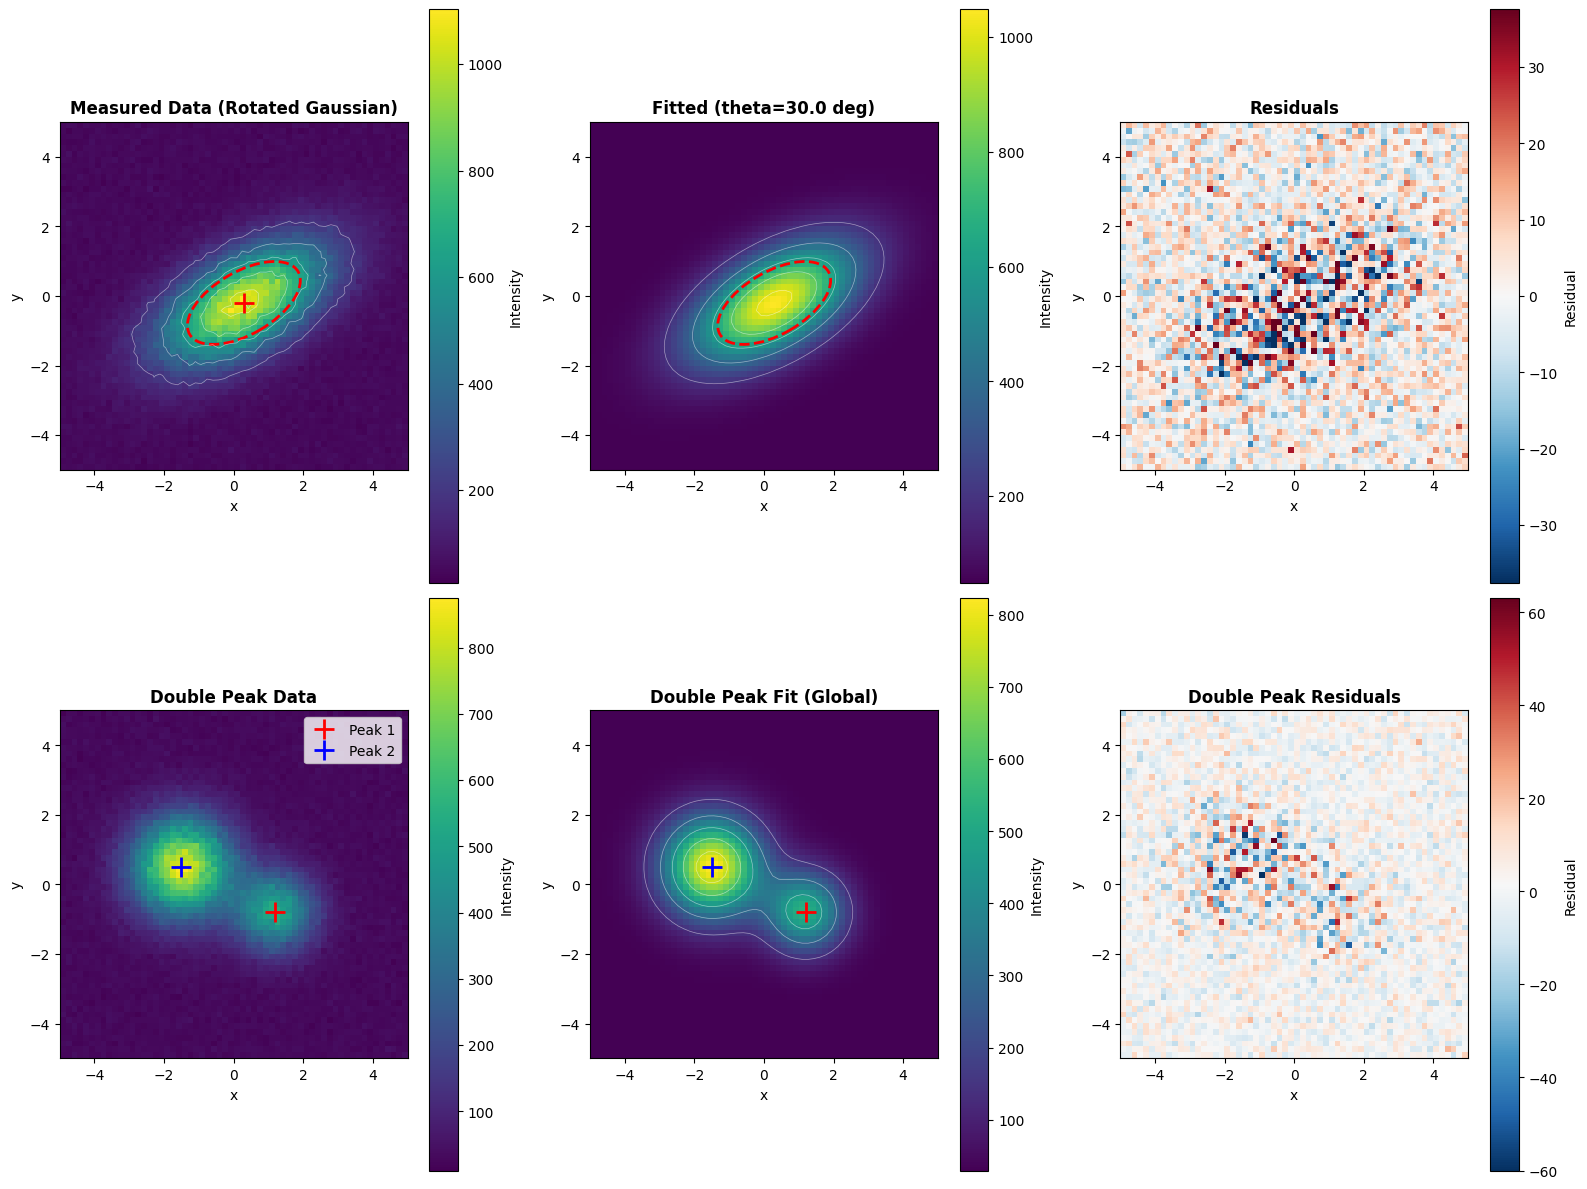


✅ Comprehensive visualization created


In [12]:
fig = plt.figure(figsize=(16, 12))

# Get actual grid dimensions from arrays (handles quick mode)
nx_actual = len(x_1d)
ny_actual = len(y_1d)

# Reshape for 2D plotting
Z_measured = z_measured.reshape(ny_actual, nx_actual)
z_fit = gaussian_2d_rotated(xdata, *popt)
Z_fit = z_fit.reshape(ny_actual, nx_actual)
Z_residuals = (z_measured - z_fit).reshape(ny_actual, nx_actual)

# Plot 1: Measured rotated Gaussian
ax1 = fig.add_subplot(2, 3, 1)
im1 = ax1.imshow(
    Z_measured,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax1.contour(X, Y, Z_measured, levels=5, colors="white", alpha=0.5, linewidths=0.5)

# Draw ellipse showing fitted orientation
ellipse = Ellipse(
    (x0_g, y0_g),
    width=2 * sx_g,
    height=2 * sy_g,
    angle=np.degrees(theta_g),
    fill=False,
    color="red",
    linewidth=2,
    linestyle="--",
)
ax1.add_patch(ellipse)
ax1.plot(x0_g, y0_g, "r+", markersize=15, markeredgewidth=2)

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Measured Data (Rotated Gaussian)", fontweight="bold")
plt.colorbar(im1, ax=ax1, label="Intensity")

# Plot 2: Fitted surface
ax2 = fig.add_subplot(2, 3, 2)
im2 = ax2.imshow(
    Z_fit,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax2.contour(X, Y, Z_fit, levels=5, colors="white", alpha=0.5, linewidths=0.5)
ellipse2 = Ellipse(
    (x0_g, y0_g),
    width=2 * sx_g,
    height=2 * sy_g,
    angle=np.degrees(theta_g),
    fill=False,
    color="red",
    linewidth=2,
    linestyle="--",
)
ax2.add_patch(ellipse2)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Fitted (theta={np.degrees(theta_g):.1f} deg)", fontweight="bold")
plt.colorbar(im2, ax=ax2, label="Intensity")

# Plot 3: Residuals
ax3 = fig.add_subplot(2, 3, 3)
residuals = z_measured - z_fit
im3 = ax3.imshow(
    Z_residuals,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="RdBu_r",
    aspect="equal",
    vmin=-3 * np.std(residuals),
    vmax=3 * np.std(residuals),
)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Residuals", fontweight="bold")
plt.colorbar(im3, ax=ax3, label="Residual")

# Plot 4: Double-peak data
Z2_measured = z2_measured.reshape(ny_actual, nx_actual)
ax4 = fig.add_subplot(2, 3, 4)
im4 = ax4.imshow(
    Z2_measured,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax4.plot(x01_fit, y01_fit, "r+", markersize=15, markeredgewidth=2, label="Peak 1")
ax4.plot(x02_fit, y02_fit, "b+", markersize=15, markeredgewidth=2, label="Peak 2")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_title("Double Peak Data", fontweight="bold")
ax4.legend()
plt.colorbar(im4, ax=ax4, label="Intensity")

# Plot 5: Double-peak fit
z2_fit = double_gaussian_2d(xdata, *popt_double)
Z2_fit = z2_fit.reshape(ny_actual, nx_actual)
ax5 = fig.add_subplot(2, 3, 5)
im5 = ax5.imshow(
    Z2_fit,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="viridis",
    aspect="equal",
)
ax5.contour(X, Y, Z2_fit, levels=5, colors="white", alpha=0.5, linewidths=0.5)
ax5.plot(x01_fit, y01_fit, "r+", markersize=15, markeredgewidth=2)
ax5.plot(x02_fit, y02_fit, "b+", markersize=15, markeredgewidth=2)
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.set_title("Double Peak Fit (Global)", fontweight="bold")
plt.colorbar(im5, ax=ax5, label="Intensity")

# Plot 6: Double-peak residuals
Z2_residuals = (z2_measured - z2_fit).reshape(ny_actual, nx_actual)
ax6 = fig.add_subplot(2, 3, 6)
im6 = ax6.imshow(
    Z2_residuals,
    extent=[x_1d.min(), x_1d.max(), y_1d.min(), y_1d.max()],
    origin="lower",
    cmap="RdBu_r",
    aspect="equal",
)
ax6.set_xlabel("x")
ax6.set_ylabel("y")
ax6.set_title("Double Peak Residuals", fontweight="bold")
plt.colorbar(im6, ax=ax6, label="Residual")

plt.tight_layout()
plt.show()

print("\n✅ Comprehensive visualization created")

## 🔑 Key Insights

### Why Global Optimization Matters for 2D Fitting:

1. **Rotation angle degeneracy:** θ and θ + π give similar profiles
   - Multi-start explores different basins
   - Finds global minimum reliably

2. **Multi-peak complexity:** 9+ parameters create many local minima
   - Single-start often finds suboptimal solutions
   - Global optimization essential for reliable results

3. **Correlated parameters:** σ_x, σ_y, θ are highly correlated
   - Local optimization can get stuck
   - Multiple starting points help escape bad valleys

### Recommended Presets for 2D Problems:

| Problem Type | Recommended Preset | n_starts |
|--------------|-------------------|----------|
| Simple 2D Gaussian (axis-aligned) | `'fast'` | - |
| Rotated 2D Gaussian | `'global'` | 10-20 |
| Multi-peak 2D | `'global'` | 15-30 |
| Complex surface (many parameters) | `'global'` | 20+ |

---

## ⚠️ Domain-Specific Considerations

**Rotation angle handling:**
- Bound θ to [-π/2, π/2] to break π-periodicity
- If θ ≈ ±π/2, consider σ_x ↔ σ_y swap
- Use `np.degrees()` for human-readable output

**Multi-peak labeling:**
- Peaks may "swap" identities during optimization
- Sort peaks by position or amplitude after fitting
- Use physical constraints to identify peaks

**Convergence indicators:**
- χ²/dof ≈ 1.0 for good fits
- Residuals should be spatially random (no patterns)
- Uncertainties should be physically reasonable

---

## 📚 Related Techniques

**Similar problems:**
- [Basic 2D Fitting](../../04_gallery/physics/surface_fitting_2d.ipynb) - Simple axis-aligned Gaussians
- [Global Optimization Basics](../../07_global_optimization/01_multistart_basics.ipynb) - Multi-start theory
- [Presets and Config](../../07_global_optimization/03_presets_and_config.ipynb) - Choosing presets

**Extensions:**
- **3+ peak fitting:** Extend double_gaussian_2d pattern
- **Rotated + multi-peak:** Combine rotation with multiple sources
- **Constrained fitting:** Fix separation or flux ratio

---

## 📖 References

**Literature:**
1. Stetson, P.B. (1987). "DAOPHOT: A computer program for crowded-field stellar photometry." *PASP* 99, 191.
2. Bertin, E. & Arnouts, S. (1996). "SExtractor: Software for source extraction." *A&AS* 117, 393.

**Theoretical background:**
- [Gaussian Function](https://en.wikipedia.org/wiki/Gaussian_function) - Wikipedia overview
- [PSF Fitting](https://en.wikipedia.org/wiki/Point_spread_function) - Point spread function fitting

**NLSQ resources:**
- [fit() API Documentation](https://nlsq.readthedocs.io/en/latest/api.html#fit)
- [Global Optimization Guide](../../07_global_optimization/)

---

## 📋 Summary

This example demonstrated:

✓ **Rotated 2D Gaussian fitting** with 7 parameters including rotation angle

✓ **Multi-peak 2D fitting** for overlapping sources (9 parameters)

✓ **fit() API with presets:** fast, robust, global for different difficulty levels

✓ **Global optimization** essential for rotated and multi-peak fits

✓ **Handling angle degeneracy** by bounding θ to [-π/2, π/2]

✓ **Derived quantities:** Peak separation, flux ratio

**Key takeaway:** For advanced 2D fitting with rotation or multiple peaks, always use `preset='global'` with sufficient starting points (10-30). The fit() API makes this easy with a single parameter change.

---

**Continue learning:**
- [Basic 2D Fitting](../../04_gallery/physics/surface_fitting_2d.ipynb) - Simpler 2D examples
- [Global Optimization](../../07_global_optimization/) - Deep dive into multi-start
- [Workflow System](../../08_workflow_system/) - Automatic preset selection